# Computing the Meridional Overturning Circulation from NEMO Output
v.1.0.2 \
René Schubert, 2021

With this script, the Meridional Overturning Circulation (MOC) can be computed from NEMO ocean-model output for the whole globe or the Atlantic (AMOC), Indic (IMOC) and Pacific (PMOC) subbasins. The MOC is computed in depth-space as $\Psi(z,y) = \int_z^0\int_{x_w}^{x_e} V(x,z')\text{ }dxdz'$, where $x$, $y$ and $z$ are zonal, meridional and vertical coordinates, the indeces $w$ and $e$ mark the western and eastern boundary and $V$ is the meridional transport. In density-space, the MOC is computed as $\Psi(\sigma_0,y) = \int_{\rho_{max}}^{\sigma_0}V(\sigma_0')\text{ }d\sigma_0'$, where $\sigma_0$ is the potential density referenced to the surface. 

\
v.1.0.1: the MOC can now be computed in density-space and from time-mean fields \
v.1.0.2: besides the global MOC and the AMOC, now also IMOC and PMOC are computable \
v.1.0.3 (future): consider variable surface cell height\
\
I thank Christina Schmidt, Franziska U. Schwarzkopf, Patrick Wagner, and Mathias Zeller for feedback and hints.

## 1. Load Necessary Modules and Start a Dask Cluster

In [1]:
import xarray as xr
import datetime
import numpy as np
import pandas as pd
import datetime
import seawater as sw

In [2]:
import dask, dask.distributed
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(cores=8,memory='50GB',processes=1,queue='large96:shared', walltime='3:00:00',interface='ib0',local_directory='$TMPDIR')
client = dask.distributed.Client(cluster)
cluster.scale(jobs=8)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.246.8.1:8787/status,
Dashboard: http://10.246.8.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.246.8.1:35355,Workers: 0
Dashboard: http://10.246.8.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## 2. Specify Paths and Configuration Details 

In [4]:
# Do you want to compute the MOC for the whole globe ('gmoc'), the Atlantic ('amoc'), the Indic ('imoc') or the Pacific ('pmoc')?
aipg_moc = 'gmoc'

# Do you want to compute the MOC in z- or sigma-space?
z_sig = 'sig' # 'z' or 'sig'

# Do you want to compute the MOC from time-average or time-stepwise fields?
# In z-space, the (A)MOC from time-stepwise fields averaged over time equals the MOC from time-average fields. This is not the case for sigma-space!
ave_step = 'step' # 'ave' or 'step'

# Do you want to take care of that the model grid is curvilinear north of 20°N? (This gets more important, the higher the latitude is.)
rot  = 0 # 1|0. If 1, the local coordinate field is rotated from x,y direction to zonal and meridional direction
regr = 0 # 1|0. If 1, the meridional flux is summed up over latitudional bands instead of in x-direction 
# CAUTION when using regr = 1:
# - it is not yet implemented for z_sig = 'sig'
# - for ave_step = 'step', for one year of global 5d data it takes ~30 min (rot = 0) respectively ~67 min (rot = 1)
# - for ave_step = 'ave', the computation time is reduced to ~1 min (rot = 0) respectively ~2.5 min (rot = 1), as the regridding needs to be performed only once.

# From which to which year do you like to perform the computations?
yeara = 2016 # first year 
yearb = 2016 # last year

# Where are the data files?
# path_data = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/' # ORION10 EXPERIMENT 5
# path_data = '/scratch/usr/shklvn09/SCRATCH/ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.LP04-KLP002.hind/OUT/' # ORCA025 HIND
# path_data = '/scratch/usr/shkifmmp/MOC/ORCA025/hind/MOC/' #for 1y
path_data = '/scratch/usr/shklvn09/SCRATCH/ORCA05.L46.LIM2vp.CFCSF6.MOPS.B.LP09-KLP002-cycle5/OUT/' #ORCA05

# Where are the mask files?
# path_mask = '/scratch/usr/shklvn09/NUDATA/ORION/10-data/meshmask/' #EXP05
# path_mask = '/scratch/usr/shklvn09/NUDATA/ORCA/025-data/meshmask/' #ORCA025
path_mask = '/scratch/usr/shklvn09/NUDATA/ORCA/05-data/meshmask/'

# Where are the subbasin mask files ('new_maskglo.nc')? 
# Can be left empty ('') for e.g. the global MOC or for the AMOC, if the Atlantic mask shall be created by the script(see below).
path_sub = '' #LEAVE EMPTY

# For AMOC computations: Do you like to use the mask from new_maskglo.nc or a one created within this script?   
atlmask_creation = 0 # 1 for creation in python, 0 for using the mask from new_maskglo.nc

# What is the name of the simulation?
# name_data = 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_' # e.g. 'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_' - EXP05
# name_data = 'ORCA025.L46.LIM2vp.CFCSF6.MOPS.JRA.LP04-KLP002.hind_' #ORCA025
name_data = 'ORCA05.L46.LIM2vp.CFCSF6.MOPS.B.LP09-KLP002-cycle5_' #ORCA05

# What is the output frequency of the data on the global grid?
freq_data_b = '5d' # e.g. '1y' or '5d' or '1d'

# Where do you want to store the results?
# path_save = '/scratch/usr/shkifmmp/MOC/EXP05/r_2000/' 
# path_save = '/scratch/usr/shkifmmp/MOC/ORCA025/hind/MOC_nb/from_1y_r2000/'
path_save = '/scratch/usr/shkifmmp/MOC/ORCA05/'

# How large should the chunks be in y-direction?
chunk_y = 20 # usually 50 worked, but not for INALT20 5d-mean nest data #15 for ORION10

# Do you want to consider nest data?
# nest = 1 # 1(yes)|0(no) -EXP05
nest = 0
# CAUTION when using nest = 1 in combination with rot = 1 and/or regr = 1: although the code is expected to work, this has not been tested yet.
# Note that the rotation and the regridding is only performed in the nest, if the nest is associated with a curvi-linear grid

# for nested configurations:
# Where is the AGRIF_FixedGrids.in?
path_agrif = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/' #for EXP05

# What is the output frequency of the data on the nest grid?
freq_data_n = '5d' # e.g. '1y' or '5d' or '1d' 
# for the case that the output frequency in the nest differs from the one in the host, at the moment only the case '5d' in the host and '1d' in the nest is implemented.
# In this case, the nest data is 5d-averaged before the (A)MOC computations.

# What level of reference for the sigma?
depth_ref = 2000

## 3. Computations

In [5]:
# compute the reference latitude and the area for meridional flux computations
ds = xr.open_dataset(path_mask+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
lat_b = ds.gphiv # load global V-grid latitudes
lat_b = lat_b.isel(x=slice(1,-1)) # remove colums at cyclic boundary
ref_lat = lat_b.max(dim='x').compute() # estimate reference latitude (for the whole globe, this is also the result if one considers only ocean cells)
area_b = (ds.e1v * ds.e3v_0)
if nest == 1:
    ds = xr.open_dataset(path_mask+'1_mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
    ds = ds.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
    lat_n = ds.gphiv # load nest V-grid latitudes
    area_n = (ds.e1v * ds.e3v_0)

In [1]:
# FOR ORCA05 e3t_0

# compute the reference latitude and the area for meridional flux computations
# ds = xr.open_dataset(path_mask+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
# lat_b = ds.gphiv # load global V-grid latitudes
# lat_b = lat_b.isel(x=slice(1,-1)) # remove colums at cyclic boundary
# ref_lat = lat_b.max(dim='x').compute() # estimate reference latitude (for the whole globe, this is also the result if one considers only ocean cells)
# area_b = (ds.e1v * ds.e3t_0)
# if nest == 1:
#     ds = xr.open_dataset(path_mask+'1_mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
#     ds = ds.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
#     lat_n = ds.gphiv # load nest V-grid latitudes
#     area_n = (ds.e1v * ds.e3t_0)

In [7]:
# if nest data shall be used, get approximate nest location in terms of respective host indeces, as well as grid-refinement (grf)
if nest == 1:
    with open(path_agrif+'AGRIF_FixedGrids.in') as f:
        agrif = [line.rstrip() for line in f]
    ia_agrif,ib_agrif,ja_agrif,jb_agrif,grf = [int(n) for n in agrif[1].split()][0:5]
    print(ia_agrif,ib_agrif,ja_agrif,jb_agrif,grf)

In [8]:
# Load (or create) subbasin masks
if aipg_moc != 'gmoc':
    if aipg_moc == 'amoc':
        if atlmask_creation == 0:
            ocmask_b = xr.open_dataset(path_sub + 'new_maskglo.nc',chunks={'X':-1,'Y':-1}).tmaskatl.rename({'Y':'y','X':'x'}).isel(x=slice(1,-1)).drop({'x','y'}) # # remove colums at cyclic boundary
            ocmask_b = ocmask_b.where(lat_b>-34.8)
        if atlmask_creation == 1:
            # load lon/lat coordinates of V-grid
            ds = xr.open_dataset(path_mask+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze().isel(x=slice(1,-1)) # remove columns at cyclic boundary 
            # cut rectangular box
            ocmask_b = ds.vmaskutil.where((ds.glamv>-100.)&(ds.glamv<20.000)&(ds.gphiv>-34.8)&(ds.gphiv<70.0))
            # cut Pacific
            ocmask_b = ocmask_b.where((ds.glamv<=-100)|(ds.glamv>=-69.5)|(ds.gphiv<=-60.)|(ds.gphiv>=7.8))
            ocmask_b = ocmask_b.where((ds.glamv<=-100)|(ds.glamv>=-89.0)|(ds.gphiv<=6.00)|(ds.gphiv>=18.))
            ocmask_b = ocmask_b.where((ds.glamv<=-90.)|(ds.glamv>=-83.7)|(ds.gphiv<=6.00)|(ds.gphiv>=15.))
            ocmask_b = ocmask_b.where((ds.glamv<=-84.)|(ds.glamv>=-77.3)|(ds.gphiv<=6.00)|(ds.gphiv>=8.5))
            ocmask_b = ocmask_b.where((ds.glamv<=-80.)|(ds.glamv>=-78.0)|(ds.gphiv<=6.00)|(ds.gphiv>=9.0))
            # cut Mediterranean Sea
            ocmask_b = ocmask_b.where((ds.glamv<=0.00)|(ds.glamv>=30.00)|(ds.gphiv<=20.0)|(ds.gphiv>=47.))
            ocmask_b = ocmask_b.where((ds.glamv<=-5.7)|(ds.glamv>=1.000)|(ds.gphiv<=35.0)|(ds.gphiv>=43.))

    if aipg_moc == 'imoc':
        ocmask_b = xr.open_dataset(path_sub + 'new_maskglo.nc',chunks={'X':-1,'Y':-1}).tmaskind.rename({'Y':'y','X':'x'}).isel(x=slice(1,-1)).drop({'x','y'}) # # remove colums at cyclic boundary
        ocmask_b = ocmask_b.where(lat_b>-34.8)
    if aipg_moc == 'pmoc':
        ocmask_b = xr.open_dataset(path_sub + 'new_maskglo.nc',chunks={'X':-1,'Y':-1}).tmaskpac.rename({'Y':'y','X':'x'}).isel(x=slice(1,-1)).drop({'x','y'}) # # remove colums at cyclic boundary     

    # For the nest-masks, the base-masks are grid-refined (e.g, the land areas stay equally large) 
    if nest == 1:
        ocmask_n = ocmask_b[ja_agrif+1:jb_agrif,ia_agrif+1-1:ib_agrif+1-1]
        ocmask_n = xr.DataArray(np.repeat(np.repeat(np.array(ocmask_n),repeats=grf,axis=0),repeats=grf,axis=1),dims=['y','x'])

In [9]:
# Compute 5d-averages of the nest data, if the data output frequency is 5d in the host and 1d in the nest.
def get_5dave(var):
    # 4.1.1 remove last day of leap years
    for year in range(yeara,yearb+1):
        if (datetime.date(year+1,1,1)-datetime.date(year,1,1)).days == 366:
            var = xr.concat((var.isel(time_counter=slice(0,((year-yeara)+1)*365)),var.isel(time_counter=slice(((year-yeara)+1)*365+1,None))),dim='time_counter')
    # 4.1.2 5d average
    time_dim1 = range(5)
    time_dim2 = var.time_counter.values[2::5]
    ind = pd.MultiIndex.from_product((time_dim2,time_dim1),names=('new_time','segment'))
    var = var.assign_coords(time_counter=ind).unstack('time_counter').mean(dim='segment').rename({'new_time':'time_counter'}).transpose("time_counter","z","y","x")
    return var

In [10]:
# get velocity component in y-direction
def get_v(start,freq):
    # set chunk size in time-dimension
    if freq == '1d':
        chunk_t = 73 # else memory issues
    else:
        chunk_t = -1  
    
    # load velocity component in y direction (equivalent to meridional velocity component south of 20°N) and cut period
    v = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_V.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthv':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vomecrty.rename({'depthv': 'z'})
    for year in range(yeara+1,yearb+1):
        v_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_V.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                              chunks={'depthv':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vomecrty.rename({'depthv': 'z'})
        v = xr.concat([v,v_tmp],dim='time_counter')
    if ave_step == 'ave':
        v = v.mean(dim='time_counter')
    if (ave_step == 'step') & (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
        # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
        v = get_5dave(v)
    return v

v_b = get_v('',freq_data_b) # global
if nest == 1:   
    v_n = get_v('1_',freq_data_n) # nest
    v_n = v_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region

In [11]:
def get_F_rot(start,freq,v,area):
    # set chunk size in time-dimension
    if freq == '1d':
        chunk_t = 73 # else memory issues
    else:
        chunk_t = -1
    # load velocity component in x direction (equivalent to zonal velocity component south of 20°N) and cut period
    u = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthu':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vozocrtx.rename({'depthu': 'z'})
    for year in range(yeara+1,yearb+1):
        u_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                              chunks={'depthu':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vozocrtx.rename({'depthu': 'z'})
        u = xr.concat([u,u_tmp],dim='time_counter')
        
    # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
    if (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
        u = get_5dave(u)
    if ave_step == 'ave':
        u = u.mean(dim='time_counter')
    # interpolation of u onto V-grid (using 0 over land)
    if start == '':
        u_tmp = xr.concat((u.isel(x=-1),u),dim='x') # add last column at first i to compute the difference for every i (not necessary in the nest)
        ui = (u_tmp.shift(x=1).isel(x=slice(1,None)) + u + u_tmp.shift(x=1,y=-1).isel(x=slice(1,None)) + u.shift(y=-1)) / 4
        # in the global grid, entries in the last row (in the "north") get NaN  
    if start == '1_':
        ui = (u.shift(x=1) + u + u.shift(x=1,y=-1) + u.shift(y=-1)) / 4
        # in the nest, entries in the first column and the last row get NaN. One further column/row in the "west" and "north" gets useless due to the "zero-frame". However they are cut anyway.

    mask = xr.open_dataset(path_mask+start+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()    
    lat = mask.gphiv # load lat coordinates of V-grid
    pi = 3.14159265359
    dlatdy = lat.shift(y=-1)-lat.shift(y=1) # entries in the first and the last row get NaN
    if start == '':
        lat_tmp = xr.concat((lat.isel(x=-1),lat,lat.isel(x=0)),dim='x') # add last column at first i and first column at last i to compute the difference for every i
        dlatdx = (lat_tmp.shift(x=-1)-lat_tmp.shift(x=1)).isel(x=slice(1,-1))                    
    if start == '1_':
        dlatdx = lat.shift(x=-1)-lat.shift(x=1)
        # in the nest, entries in the first and last column (west and east) get NaN, but are cut anyway afterwards

    angle = -1*(xr.ufuncs.arccos(((dlatdx)/(dlatdx**2+dlatdy**2)**0.5))*(180/pi) - 90)
    cosa = xr.ufuncs.cos(angle/(180/pi))
    sina = xr.ufuncs.sin(angle/(180/pi))
    v_rot = (v/sina+ui/cosa) / (cosa/sina+sina/cosa)
    v_rot = v_rot.fillna(0) + v.where(xr.ufuncs.isnan(v_rot)==1,other=0) # replace v values by original ones, where v_rot is nan (mainly south of 20°N)
    
    # multiply with the respective vertical area of the grid-cell to get meridional flux
    F = -1 * v_rot * area / cosa /1e6 # in Sv and with positive clockwise rotation sense
    return F

In [12]:
# compute meridional flux
if rot == 0:
    F_b = -1 * v_b * area_b / 1e6 # in Sv and with positive clockwise rotation sense
if rot == 1: # rotate the local coordinate system from x,y to zonal,meridional
    F_b = get_F_rot('',freq_data_b,v_b,area_b)
F_b = F_b.isel(x=slice(1,-1)) # remove cell columns along the cyclic boundary
if aipg_moc != 'gmoc': # cut subbasin
    F_b = F_b.where(ocmask_b==1)
if nest == 1: 
    if (rot == 0) | ((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) == 0): # check, whether the nest data is on a regular grid
        F_n = -1 * v_n * area_n / 1e6 # in Sv and with positive clockwise rotation sense
    else: # rotate the local coordinate system from x,y to zonal,meridional
        F_n = get_F_rot('1_',freq_data_n,v_n,area_n)
    #F_n = F_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
    if aipg_moc != 'gmoc': # cut subbasin
        F_n = F_n.where(ocmask_n==1)

In [13]:
# get potential density referenced to the surface on the T-grid for s-MOC computations
def get_sigma(start,freq): 
    # set chunk size in time-dimension
    if freq == '1d':
        chunk_t = 73 # else memory issues
    else:
        chunk_t = -1
    # use eos80 (as this has been used for the simulations)
    
    # load potential temperature
    t = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_T.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                          chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().votemper.rename({'deptht': 'z'}) #taking #.squeeze() out for 1y before .variable
    for year in range(yeara+1,yearb+1):
        t_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                              chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().votemper.rename({'deptht': 'z'}) #here
        t = xr.concat([t,t_tmp],dim='time_counter')
    
    # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
    if ave_step == 'ave':
        t = t.mean(dim='time_counter')
    else:
        if (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
            t = get_5dave(t)
    
        
    # load salinity
    s = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_T.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                          chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vosaline.rename({'deptht': 'z'}) # here
    for year in range(yeara+1,yearb+1):
        s_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
                              chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vosaline.rename({'deptht': 'z'}) #here
        s = xr.concat([s,s_tmp],dim='time_counter')
    # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
    if ave_step == 'ave':
        s = s.mean(dim='time_counter')
    else:
        if (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
            s = get_5dave(s)
    
        
    # compute pressure 
    # load latitudes and depth of V-grid
    ds = xr.open_dataset(path_mask+start+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
    lat = ds.gphiv
    dep = ds.gdepv
    p = xr.apply_ufunc(sw.eos80.pres,dep,lat,dask = 'parallelized',output_dtypes=[np.float])
    p = p.assign_coords({'z':t.z})
    
    # compute potential density
    t = xr.apply_ufunc(sw.eos80.temp,s,t,p,0,dask = 'parallelized',output_dtypes=[np.float])
    sig = xr.apply_ufunc(sw.eos80.pden,s,t,p,depth_ref,dask = 'parallelized',output_dtypes=[np.float]) # compute potential density
    sig -= 1000
    sig = sig.where(s!=0)
    
    # remove cell-columns along the cyclic boundary        
    if start == '':
        sig = sig.isel(x=slice(1,-1))        
    return sig

if z_sig == 'sig':
    # create sigma vector and respective lower (and upper) bounds
#     sigmin,sigmax,sigstp = 23.,31.,0.1 #for surface
    sigmin,sigmax,sigstp = 30.,38.,0.1 #ref=2000
    sig_vec = np.arange(sigmin+sigstp/2.,sigmax-sigstp,sigstp)
    sig_lo = xr.DataArray(np.arange(sigmin,sigmin+((sigmax-sigmin)/sigstp-1)*sigstp,sigstp),dims='sigma').chunk({'sigma':-1})
    sig_b = get_sigma('',freq_data_b)
    if ave_step == 'step':
        sig_b = sig_b.chunk({'time_counter':1})   
    if aipg_moc != 'gmoc':
        sig_b = sig_b.where(ocmask_b==1)
    if nest == 1:
        sig_n = get_sigma('1_',freq_data_n)
        if ave_step == 'step':
            sig_n = sig_n.chunk({'time_counter':1})
        sig_n = sig_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
        if aipg_moc != 'gmoc':
            sig_n = sig_n.where(ocmask_n==1)

In [14]:
# FOR ORCA05

# get potential density referenced to the surface on the T-grid for s-MOC computations
# def get_sigma(start,freq): 
#     # set chunk size in time-dimension
#     if freq == '1d':
#         chunk_t = 73 # else memory issues
#     else:
#         chunk_t = -1
#     # use eos80 (as this has been used for the simulations)
    
#     # load potential temperature
#     t = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_T.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
#                           chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().votemper.rename({'deptht': 'z'}) #taking #.squeeze() out for 1y before .variable
#     for year in range(yeara+1,yearb+1):
#         t_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
#                               chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().votemper.rename({'deptht': 'z'}) #here
#         t = xr.concat([t,t_tmp],dim='time_counter')
    
#     # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
#     if ave_step == 'ave':
#         t = t.mean(dim='time_counter')
#     else:
#         if (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
#             t = get_5dave(t)
    
        
#     # load salinity
#     s = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(yeara)+'*_grid_T.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
#                           chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vosaline.rename({'deptht': 'z'}) # here
#     for year in range(yeara+1,yearb+1):
#         s_tmp = xr.open_mfdataset(path_data+start+name_data+freq+'_'+str(year)+'*_grid_U.nc',combine='nested',concat_dim='time_counter', decode_cf=False,
#                               chunks={'deptht':-1,'time_counter':chunk_t,'x':-1,'y':chunk_y}).squeeze().vosaline.rename({'deptht': 'z'}) #here
#         s = xr.concat([s,s_tmp],dim='time_counter')
#     # average the nest data temporally onto the global data if the output-frequency of the nest is daily and the one of the host is 5-daily
#     if ave_step == 'ave':
#         s = s.mean(dim='time_counter')
#     else:
#         if (start == '1_') & (freq == '1d') & (freq_data_b == '5d'):
#             s = get_5dave(s)
    
        
#     # compute pressure 
#     # load latitudes and depth of V-grid
#     ds = xr.open_dataset(path_mask+start+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
#     lat = ds.gphiv
#     dep = ds.gdept_0
#     p = xr.apply_ufunc(sw.eos80.pres,dep,lat,dask = 'parallelized',output_dtypes=[np.float])
#     p = p.assign_coords({'z':t.z})
    
#     # compute potential density
#     t = xr.apply_ufunc(sw.eos80.temp,s,t,p,0,dask = 'parallelized',output_dtypes=[np.float])
#     sig = xr.apply_ufunc(sw.eos80.pden,s,t,p,depth_ref,dask = 'parallelized',output_dtypes=[np.float]) # compute potential density
#     sig -= 1000
#     sig = sig.where(s!=0)
    
#     # remove cell-columns along the cyclic boundary        
#     if start == '':
#         sig = sig.isel(x=slice(1,-1))        
#     return sig

# if z_sig == 'sig':
#     # create sigma vector and respective lower (and upper) bounds
# #     sigmin,sigmax,sigstp = 23.,31.,0.1 #for surface
#     sigmin,sigmax,sigstp = 30.,38.,0.1 #ref=2000
#     sig_vec = np.arange(sigmin+sigstp/2.,sigmax-sigstp,sigstp)
#     sig_lo = xr.DataArray(np.arange(sigmin,sigmin+((sigmax-sigmin)/sigstp-1)*sigstp,sigstp),dims='sigma').chunk({'sigma':-1})
#     sig_b = get_sigma('',freq_data_b)
#     if ave_step == 'step':
#         sig_b = sig_b.chunk({'time_counter':1})   
#     if aipg_moc != 'gmoc':
#         sig_b = sig_b.where(ocmask_b==1)
#     if nest == 1:
#         sig_n = get_sigma('1_',freq_data_n)
#         if ave_step == 'step':
#             sig_n = sig_n.chunk({'time_counter':1})
#         sig_n = sig_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
#         if aipg_moc != 'gmoc':
#             sig_n = sig_n.where(ocmask_n==1)

/scratch/tmp/shkifmmp/ipykernel_199289/591209149.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = xr.apply_ufunc(sw.eos80.pres,dep,lat,dask = 'parallelized',output_dtypes=[np.float])
/scratch/tmp/shkifmmp/ipykernel_199289/591209149.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = xr.apply_ufunc(sw.eos80.temp,s,t,p,0,dask =

In [15]:
# prepare regridding
if regr == 1:
    if z_sig == 'sig':
        print('REGRIDDING IS NOT YET IMPLEMENTED FOR THE SIGMA-MOC!')
    ref_lat_tmp = xr.DataArray(np.array(ref_lat),dims='yref').chunk({'yref':-1})
    latdiff = (ref_lat_tmp-ref_lat_tmp.shift(yref=1)).isel(yref=slice(1,None))/2
    lat_lo = ref_lat_tmp - xr.concat((latdiff.isel(yref=0),latdiff),dim='yref').chunk({'yref':-1})
    lat_up = ref_lat_tmp + xr.concat((latdiff,latdiff.isel(yref=-1)),dim='yref').chunk({'yref':-1})
    
    F_b = F_b.chunk({'x':200})
    if ave_step == 'step':
        F_b = F_b.chunk({'time_counter':1})
    if nest == 1:
        F_n = F_n.chunk({'x':200})
        if ave_step == 'step':
            F_n = F_n.chunk({'time_counter':1})

In [16]:
%%time
# compute the MOC
if nest == 0:
    if z_sig == 'z':
        if regr == 1: # sum up over latitudional bands        
            moc = F_b.where(((lat_b > lat_lo) & (lat_b <= lat_up))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
        else: # sum up in x-direction        
            moc = F_b.sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute()
    if z_sig == 'sig':
        if regr == 1: # sum up over latitudional bands        
            print('ERROR - regridding for s-(A)MOC not implemented yet')
        else: # sum up in x-direction        
            moc = F_b.where(sig_b >= sig_lo).sum(dim={'x','z'}).compute()
            if ave_step == 'ave':
                moc = moc.T
            if ave_step == 'step':
                moc = moc.transpose("time_counter","sigma","y")
            
if nest == 1:
    # 1. compute MOC based on global data without nest domain
    mask = np.zeros((lat_b.shape))+1
    mask[ja_agrif+1:jb_agrif,ia_agrif+1-1:ib_agrif+1-1] = 0 # cut comparable area (one column shifted in negative x-direction to account for removed columns at cyclic boundaries)
    mask = xr.DataArray(mask,dims=['y','x'])
    if z_sig == 'z':
        if regr == 1: # sum up over latitudional bands
            moc_wonest = (F_b*mask).where(((lat_b > lat_lo) & (lat_b <= lat_up))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
        else: # sum up in x-direction
            moc_wonest = (F_b*mask).sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute() # reverse z-axis to integrate from bottom to surface
    if z_sig == 'sig':
        if regr == 1: # sum up over latitudional bands
            print('ERROR - regridding for s-(A)MOC not implemented yet')
        else: # sum up in x-direction
            moc_wonest = (F_b*mask).where(sig_b >= sig_lo).sum(dim={'x','z'}).compute()
    # 2. compute MOC in the nest domain
    if z_sig == 'z':
        if (regr == 1)&((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) != 0): # sum up over latitudional bands
            moc_n = F_n.where(((lat_n > lat_lo[ja_agrif+1:jb_agrif]) & (lat_n <= lat_up[ja_agrif+1:jb_agrif]))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
        else:
            moc_n = F_n.sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute() # reverse z-axis to integrate from bottom to surface
    if z_sig == 'sig':
        if (regr == 1)&((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) != 0): # sum up over latitudional bands
            print('ERROR - regridding for s-(A)MOC not implemented yet')
        else:
            moc_n = F_n.where(sig_n >= sig_lo).sum(dim={'x','z'}).compute()
    # 3. add nest moc to global moc
    if regr == 0: # average spatially before
        y_dim1 = range(grf)
        y_dim2 = moc_n.y.values[2::grf]
        ind = pd.MultiIndex.from_product((y_dim2,y_dim1),names=('new_y','segment'))
        moc_n = moc_n.assign_coords(y=ind).unstack('y').mean(dim='segment').rename({'new_y':'y'})
        if z_sig == 'sig':
            if ave_step =='step':
                moc_n = moc_n.transpose("time_counter","sigma","y")
                moc_wonest = moc_wonest.transpose("time_counter","sigma","y")
            if ave_step =='ave':
                moc_n = moc_n.transpose("sigma","y")
                moc_wonest = moc_wonest.transpose("sigma","y")
    moc = moc_wonest.copy()
    if ave_step == 'ave':
        moc[:,ja_agrif+1:jb_agrif] += np.array(moc_n)
    if ave_step == 'step':   
        moc[:,:,ja_agrif+1:jb_agrif] += np.array(moc_n)

CPU times: user 36.4 s, sys: 2.02 s, total: 38.5 s
Wall time: 4min 33s


In [17]:
%%time
# save data
moc = moc.rename('moc')
moc = moc.assign_coords({'y':ref_lat.values})
if z_sig == 'sig':
    moc = moc.assign_coords({'sigma':xr.DataArray(sig_vec,dims='sigma')})
moc.to_netcdf(path_save+name_data[:-2]+'_'+str(yeara)+'_'+str(yearb)+'_'+aipg_moc+'_rot'+str(rot)+'_regr'+str(regr)+'_nest'+str(nest)+'_'+ave_step+'_'+z_sig+'.nc')

CPU times: user 16.4 ms, sys: 29.2 ms, total: 45.7 ms
Wall time: 67.3 ms


In [18]:
# From which to which year do you like to perform the computations?
def run_moc(year1,year2):
    while year1 <= year2:
        globals()['yeara'] = year1 # first year - stoped at 1981 for EXP05
        globals()['yearb'] = year1 # last year

        
        v_b = get_v('',freq_data_b) # global
        if nest == 1:   
            v_n = get_v('1_',freq_data_n) # nest
            v_n = v_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
            
        # compute meridional flux
        if rot == 0:
            F_b = -1 * v_b * area_b / 1e6 # in Sv and with positive clockwise rotation sense
        if rot == 1: # rotate the local coordinate system from x,y to zonal,meridional
            F_b = get_F_rot('',freq_data_b,v_b,area_b)
        F_b = F_b.isel(x=slice(1,-1)) # remove cell columns along the cyclic boundary
        if aipg_moc != 'gmoc': # cut subbasin
            F_b = F_b.where(ocmask_b==1)
        if nest == 1: 
            if (rot == 0) | ((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) == 0): # check, whether the nest data is on a regular grid
                F_n = -1 * v_n * area_n / 1e6 # in Sv and with positive clockwise rotation sense
            else: # rotate the local coordinate system from x,y to zonal,meridional
                F_n = get_F_rot('1_',freq_data_n,v_n,area_n)
            #F_n = F_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
            if aipg_moc != 'gmoc': # cut subbasin
                F_n = F_n.where(ocmask_n==1)
                
        if z_sig == 'sig':
            # create sigma vector and respective lower (and upper) bounds
#             sigmin,sigmax,sigstp = 23.,31.,0.1
            sigmin,sigmax,sigstp = 30.,38.,0.1 #r2000
            sig_vec = np.arange(sigmin+sigstp/2.,sigmax-sigstp,sigstp)
            sig_lo = xr.DataArray(np.arange(sigmin,sigmin+((sigmax-sigmin)/sigstp-1)*sigstp,sigstp),dims='sigma').chunk({'sigma':-1})
            sig_b = get_sigma('',freq_data_b)
            if ave_step == 'step':
                sig_b = sig_b.chunk({'time_counter':1})   
            if aipg_moc != 'gmoc':
                sig_b = sig_b.where(ocmask_b==1)
            if nest == 1:
                sig_n = get_sigma('1_',freq_data_n)
                if ave_step == 'step':
                    sig_n = sig_n.chunk({'time_counter':1})
                sig_n = sig_n.isel(y=slice(4,-5),x=slice(2,-2)) # cut comparable region
                if aipg_moc != 'gmoc':
                    sig_n = sig_n.where(ocmask_n==1)
                    
        # prepare regridding
        if regr == 1:
            if z_sig == 'sig':
                print('REGRIDDING IS NOT YET IMPLEMENTED FOR THE SIGMA-MOC!')
            ref_lat_tmp = xr.DataArray(np.array(ref_lat),dims='yref').chunk({'yref':-1})
            latdiff = (ref_lat_tmp-ref_lat_tmp.shift(yref=1)).isel(yref=slice(1,None))/2
            lat_lo = ref_lat_tmp - xr.concat((latdiff.isel(yref=0),latdiff),dim='yref').chunk({'yref':-1})
            lat_up = ref_lat_tmp + xr.concat((latdiff,latdiff.isel(yref=-1)),dim='yref').chunk({'yref':-1})

            F_b = F_b.chunk({'x':200})
            if ave_step == 'step':
                F_b = F_b.chunk({'time_counter':1})
            if nest == 1:
                F_n = F_n.chunk({'x':200})
                if ave_step == 'step':
                    F_n = F_n.chunk({'time_counter':1})
                    
        
        # compute the MOC
        if nest == 0:
            if z_sig == 'z':
                if regr == 1: # sum up over latitudional bands        
                    moc = F_b.where(((lat_b > lat_lo) & (lat_b <= lat_up))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
                else: # sum up in x-direction        
                    moc = F_b.sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute()
            if z_sig == 'sig':
                if regr == 1: # sum up over latitudional bands        
                    print('ERROR - regridding for s-(A)MOC not implemented yet')
                else: # sum up in x-direction        
                    moc = F_b.where(sig_b >= sig_lo).sum(dim={'x','z'}).compute()
                    if ave_step == 'ave':
                        moc = moc.T
                    if ave_step == 'step':
                        moc = moc.transpose("time_counter","sigma","y")
            
        if nest == 1:
            # 1. compute MOC based on global data without nest domain
            mask = np.zeros((lat_b.shape))+1
            mask[ja_agrif+1:jb_agrif,ia_agrif+1-1:ib_agrif+1-1] = 0 # cut comparable area (one column shifted in negative x-direction to account for removed columns at cyclic boundaries)
            mask = xr.DataArray(mask,dims=['y','x'])
            if z_sig == 'z':
                if regr == 1: # sum up over latitudional bands
                    moc_wonest = (F_b*mask).where(((lat_b > lat_lo) & (lat_b <= lat_up))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
                else: # sum up in x-direction
                    moc_wonest = (F_b*mask).sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute() # reverse z-axis to integrate from bottom to surface
            if z_sig == 'sig':
                if regr == 1: # sum up over latitudional bands
                    print('ERROR - regridding for s-(A)MOC not implemented yet')
                else: # sum up in x-direction
                    moc_wonest = (F_b*mask).where(sig_b >= sig_lo).sum(dim={'x','z'}).compute()
            # 2. compute MOC in the nest domain
            if z_sig == 'z':
                if (regr == 1)&((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) != 0): # sum up over latitudional bands
                    moc_n = F_n.where(((lat_n > lat_lo[ja_agrif+1:jb_agrif]) & (lat_n <= lat_up[ja_agrif+1:jb_agrif]))).sum(dim={'x','y'}).sortby('z', ascending=False).cumsum(dim='z').rename({'yref':'y'}).compute()
                else:
                    moc_n = F_n.sum(dim={'x'}).sortby('z', ascending=False).cumsum(dim='z').compute() # reverse z-axis to integrate from bottom to surface
            if z_sig == 'sig':
                if (regr == 1)&((lat_n-lat_n.isel(x=0)).sum(dim={'x','y'}) != 0): # sum up over latitudional bands
                    print('ERROR - regridding for s-(A)MOC not implemented yet')
                else:
                    moc_n = F_n.where(sig_n >= sig_lo).sum(dim={'x','z'}).compute()
            # 3. add nest moc to global moc
            if regr == 0: # average spatially before
                y_dim1 = range(grf)
                y_dim2 = moc_n.y.values[2::grf]
                ind = pd.MultiIndex.from_product((y_dim2,y_dim1),names=('new_y','segment'))
                moc_n = moc_n.assign_coords(y=ind).unstack('y').mean(dim='segment').rename({'new_y':'y'})
                if z_sig == 'sig':
                    if ave_step =='step':
                        moc_n = moc_n.transpose("time_counter","sigma","y")
                        moc_wonest = moc_wonest.transpose("time_counter","sigma","y")
                    if ave_step =='ave':
                        moc_n = moc_n.transpose("sigma","y")
                        moc_wonest = moc_wonest.transpose("sigma","y")
            moc = moc_wonest.copy()
            if ave_step == 'ave':
                moc[:,ja_agrif+1:jb_agrif] += np.array(moc_n)
            if ave_step == 'step':   
                moc[:,:,ja_agrif+1:jb_agrif] += np.array(moc_n)
                
        # save data
        moc = moc.rename('moc')
        moc = moc.assign_coords({'y':ref_lat.values})
        if z_sig == 'sig':
            moc = moc.assign_coords({'sigma':xr.DataArray(sig_vec,dims='sigma')})
        moc.to_netcdf(path_save+name_data[:-2]+'_'+str(yeara)+'_'+str(yearb)+'_'+aipg_moc+'_rot'+str(rot)+'_regr'+str(regr)+'_nest'+str(nest)+'_'+ave_step+'_'+z_sig+'.nc')
        
        year1+=1

In [19]:
run_moc(2017,2018)

/scratch/tmp/shkifmmp/ipykernel_199289/591209149.py:47: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  p = xr.apply_ufunc(sw.eos80.pres,dep,lat,dask = 'parallelized',output_dtypes=[np.float])
/scratch/tmp/shkifmmp/ipykernel_199289/591209149.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t = xr.apply_ufunc(sw.eos80.temp,s,t,p,0,dask =

In [ ]:
# Computing times for one year of 5d-mean data from INALT20r (1d means in the nest).

# MOC: (AMOC computations are not much cheaper)

# z-space
# 30 s    - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_ave_z.nc
# 30 s    - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_step_z.nc
# 47 s    - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr0_nest0_step_z.nc
# 47 s    - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr1_nest0_ave_z.nc
# 60 s    - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr1_nest0_ave_z.nc
# 2.5 min - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest1_step_z.nc
# 46 min  - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr1_nest0_step_z.nc # regridding timestep-wise fields takes long!
# 58 min  - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr1_nest0_step_z.nc # regridding timestep-wise fields takes long!

# s-space
# 1 min   - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_ave_sig.nc
# 5 min   - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_step_sig.nc
# 7 min   - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr0_nest0_step_sig.nc
# 19 min  - INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest1_step_sig.nc

## 4. Plot the time-mean (A)MOC

In [18]:
import matplotlib.pyplot as plt

/scratch/tmp/shkifmmp/ipykernel_141806/4039488415.py:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cp = plt.pcolormesh(ref_lat,vertvar,moc,vmin=plotvec.min(),vmax=plotvec.max(),cmap='seismic')


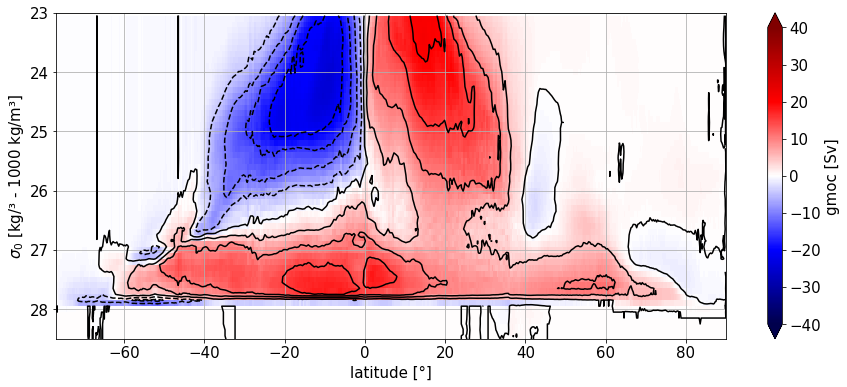

In [19]:
plt.figure(figsize=(15,6))

if ave_step == 'step':
    moc = moc.mean(dim='time_counter')

if z_sig == 'z':
    vertvar = moc.z
    plt.ylabel('depth [m]',fontsize=15)
    
if z_sig == 'sig':
    sigmin,sigmax,sigstp = 23.,31.,0.1
    sig_vec = np.arange(sigmin+sigstp/2.,sigmax-sigstp,sigstp)
    vertvar = moc.sigma
    plt.ylim(23,28.5)
    plt.ylabel('$\sigma_0$ [kg/³ - 1000 kg/m³]',fontsize=15)

if aipg_moc == 'gmoc':  
    plotvec = np.arange(-40.,45.,5.)
if aipg_moc == 'amoc':
    plotvec = np.arange(-40.,45.,5.)
    plt.xlim(-34.8,70)
if aipg_moc == 'imoc':
    plt.xlim(-34.8,30)
    plotvec = np.arange(-20.,22.,2.)
if aipg_moc == 'pmoc':
    #plt.xlim(-34.8,70)
    plotvec = np.arange(-40.,45.,5.)
        
    
cp = plt.pcolormesh(ref_lat,vertvar,moc,vmin=plotvec.min(),vmax=plotvec.max(),cmap='seismic')
plt.contour(ref_lat,vertvar,moc,plotvec,colors='k')
cbar = plt.colorbar(cp,extend = 'both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label(aipg_moc + ' [Sv]',fontsize=15)
plt.gca().invert_yaxis()

plt.xlabel('latitude [°]',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

# Appendix I: Compare the Results to CDFTOOLS
Here, we show that this script produces similar results for the MOC in z- and sigma-space as the CDFTOOL routines cdfmoc and cdfsigmoc. We compare the time-mean MOC for the year 2015 from INALT20r.L46-KRS0202 output. For the computation of the MOC with cdfmoc, it is necessary to use a respective new_maskglo.nc. Else, the first and the last grid-cell column (which are related to the cyclic boundary treatment) are spuriously considered in the computations. Further, note that the output of cdfmocsig has to be shifted by one sigma-cell to correspond to the respective python results (which are thought to be correct in the way computed in this script). Moreover, the potential density referenced to the surface computed with python seawater (this script) is found to be slightly but systematically larger than the one from cdfsig0. If the potential density from cdfsig0 is used in this script, the differences in the sigma-MOC computations are reduced by one order to O(0.01 Sv) and are more patchy. With the python seawater potential density, the differences show some patterns and are O(0.1 Sv), which is however still very small compared to the absolute values.

In [406]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

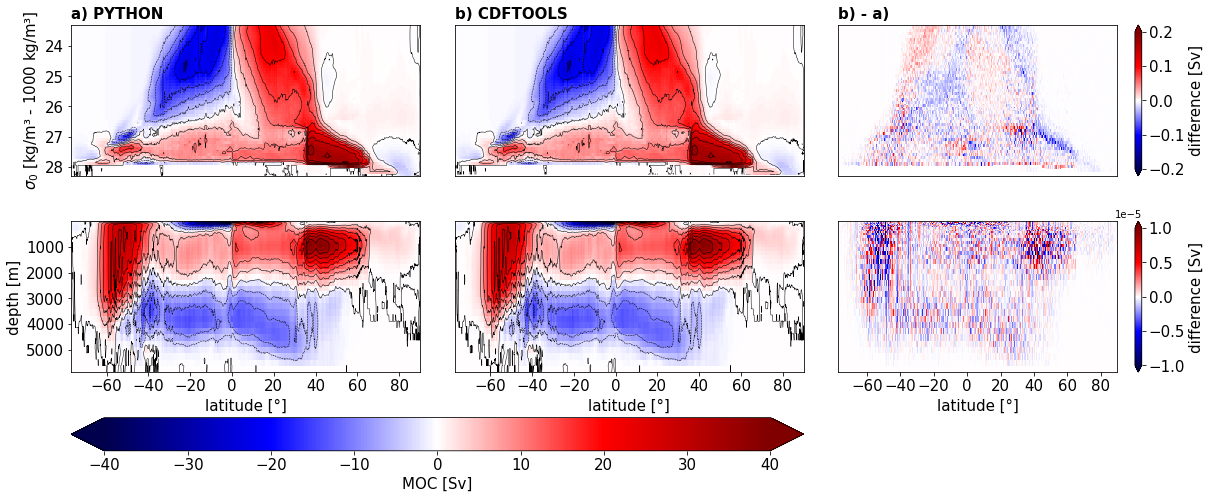

In [408]:
path_mask = '/home/shkrschu/_work/MASKS/INALT20r.L46-KRS001/'
ds = xr.open_dataset(path_mask+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze()
lat_b = ds.gphiv # load global V-grid latitudes
lat_b = lat_b.isel(x=slice(1,-1)) # remove colums at cyclic boundary
ref_lat = lat_b.max(dim='x').compute() # estimate reference latitude (identical to CDFTOOLS)

path_tmp = '/home/shkrschu/_work/ANALYSIS/MOC/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202/'
# z-MOC
moc_m_cdf = xr.open_dataset(path_tmp + 'CDFTOOLS/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_cdfmoc.nc').squeeze().mean(dim='time_counter').zomsfglo
moc_m_cdf = moc_m_cdf.sortby('depthw', ascending=True)
moc_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_ave_z.nc').__xarray_dataarray_variable__

# sigma-MOC
mocsig_m_cdf = xr.open_dataset(path_tmp + 'CDFTOOLS/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_cdfmocsig.nc').squeeze().mean(dim='time_counter').zomsfglo
# cdfmocsig: For reference depth 0.0 m, You are using -sigmin 23.00 -sigstp  0.10 -nbins  52
sigmin,sigmax,sigstp = 23.,31.,0.1
sig_vec = np.arange(sigmin+sigstp/2.,sigmax-sigstp,sigstp)
mocsig_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest0_step_sig.nc').__xarray_dataarray_variable__.mean(dim='time_counter')

plt.figure(figsize=(20,10))
gs=GridSpec(3,3) # rows, columns
gs.update(wspace=0.1, hspace=0.3)

def addplot():
    plt.gca().invert_yaxis()
    plt.ylim(28.3,23.3)
    plt.ylabel(r'$\sigma_0$ [kg/m³ - 1000 kg/m³]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
ax = plt.subplot(gs[0,0])
plt.pcolormesh(ref_lat,sig_vec,mocsig_m,vmin=-40,vmax=40,cmap='seismic')
plt.contour(ref_lat,sig_vec,mocsig_m,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('a) PYTHON',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,1])
plt.pcolormesh(ref_lat,sig_vec[:52]+0.1,mocsig_m_cdf,vmin=-40,vmax=40,cmap='seismic')
plt.contour(ref_lat,sig_vec[:52]+0.1,mocsig_m_cdf,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('b) CDFTOOLS',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,2])
diff = np.array(mocsig_m_cdf)[:-1,:]-mocsig_m[1:-27,]
plt.pcolormesh(ref_lat,sig_vec[1:52],diff.where(diff!=0),vmin=-0.2,vmax=0.2,cmap='seismic')
plt.title('b) - a)',fontsize=15,fontweight='bold',loc='left')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)


def mocplot(var,abs_diff):
    # remove "northernmost" cells, as the values are NaN there, when v is rotated to meridional before 
    if abs_diff == 'abs':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-40,vmax=40,cmap='seismic')
        plt.contour(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],np.arange(-40,45,5),colors='k',linewidths=0.5)
    if abs_diff == 'diff':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-1e-5,vmax=1e-5,cmap='seismic')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('depth [m]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    return cp

ax = plt.subplot(gs[1,0])
cp=mocplot(moc_m,'abs')

ax = plt.subplot(gs[1,1])
cp=mocplot(moc_m_cdf,'abs')
ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[1,2])
diff = np.array(moc_m_cdf) - np.array(moc_m)
cpd=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)


ax = plt.subplot(gs[-1,:2])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,extend = 'both',orientation='horizontal',fraction = 1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('MOC [Sv]',fontsize=15)

# Appendix II: Take into account the Curvilinearity of the Grid

## Rotate the local coordinate system from x,y direction to zonal and meridional direction 

In [409]:
# demonstrate coordinate-system rotation with a surface snapshot
v_tmp = xr.open_mfdataset('/home/shkrschu/_work/SCRATCH/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202/OUT/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_5d_2015*_grid_V.nc',
                          combine='by_coords',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthv':-1,'time_counter':-1,'x':-1,'y':50}).squeeze().vomecrty.rename({'depthv': 'z'})
v_tmp = v_tmp.isel(time_counter=0,z=0)
u_tmp = xr.open_mfdataset('/home/shkrschu/_work/SCRATCH/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202/OUT/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_5d_2015*_grid_U.nc',
                          combine='by_coords',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthu':-1,'time_counter':-1,'x':-1,'y':50}).squeeze().vozocrtx.rename({'depthu': 'z'})
u_tmp = u_tmp.isel(time_counter=0,z=0)

v_rot = (v_tmp/sina+u_tmp/cosa) / (cosa/sina+sina/cosa) # here, u is taken for simplicity from the U-grid. in the computations, it is interpolated onto the V-grid
v_rot = v_rot.fillna(0) + v_tmp.where(xr.ufuncs.isnan(v_rot)==1,other=0) # replace v values by original ones, where v_rot is nan (mainly south of 20°N)

/home/shkrschu/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: No contour levels were found within the data range.
  


Text(0, 0.5, 'j')

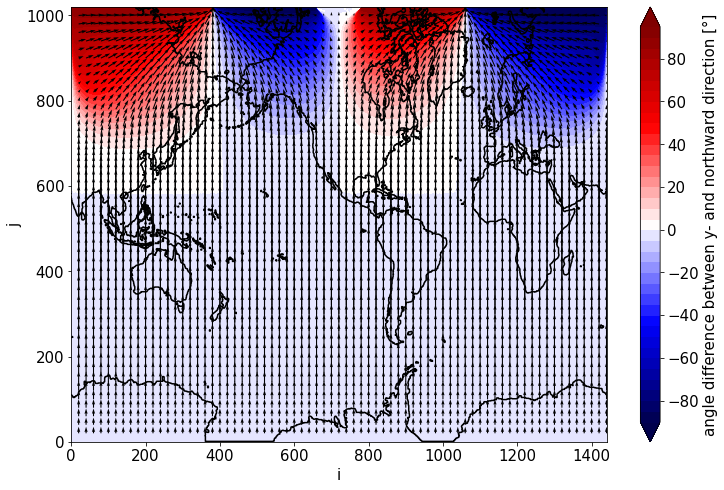

In [410]:
pi = 3.14159265359
lat_b = xr.open_dataset(path_mask+'mesh_mask.nc',chunks={'z':-1,'x':-1,'y':-1}).squeeze().gphiv # load global V-grid latitudes
dlatdy = lat_b.shift(y=-1)-lat_b.shift(y=1)
dlatdx = lat_b.shift(x=-1)-lat_b.shift(x=1)
angle = -1*(xr.ufuncs.arccos(((dlatdx)/(dlatdx**2+dlatdy**2)**0.5))*(180/pi) - 90)
cosa = xr.ufuncs.cos(angle/(180/pi))
sina = xr.ufuncs.sin(angle/(180/pi))

plt.figure(figsize=(12,8))
cp = plt.contourf(np.arange(0,angle.shape[1]),np.arange(0,angle.shape[0]),angle,np.arange(-90,100,5),cmap='seismic',extend='both')
cbar = plt.colorbar(cp,extend = 'both')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('angle difference between y- and northward direction [°]',fontsize=15)
plt.contour((v_tmp==0),0,colors='k')

nn = 20
plt.quiver(np.arange(0,angle.shape[1])[::nn],np.arange(0,angle.shape[0])[::nn],dlatdx[::nn,::nn],dlatdy[::nn,::nn],scale=10,width=0.002)
#plt.axis([700,1300,400,1000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('i',fontsize=15)
plt.ylabel('j',fontsize=15)

Northward pointing arrows show the curvilinearity of the grid.

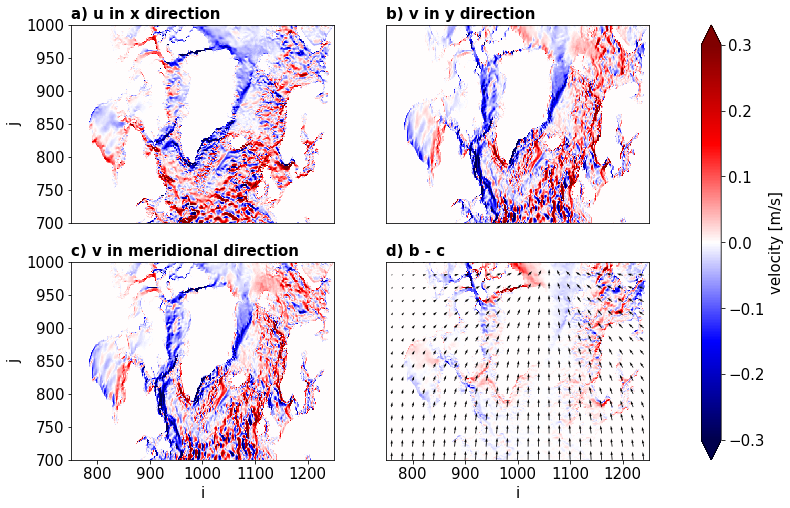

In [411]:
def addplot(var,varname):
    cp = plt.pcolormesh(var,vmin = -0.3,vmax=0.3,cmap='seismic')
    plt.axis([750,1250,700,1000])
    plt.title(varname,fontsize=15,fontweight='bold',loc='left')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('i',fontsize=15)
    plt.ylabel('j',fontsize=15)
    return cp

plt.figure(figsize=(16,8))
gs=GridSpec(2,3) # rows, columns
gs.update(wspace=0.2, hspace=0.2)

ax = plt.subplot(gs[0,0])
cp = addplot(u_tmp,'a) u in x direction')
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,1])
cp = addplot(v_tmp,'b) v in y direction')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[1,0])
cp = addplot(v_rot,'c) v in meridional direction')

ax = plt.subplot(gs[1,1])
cp = addplot((v_tmp-v_rot),'d) b - c')
ax.get_yaxis().set_visible(False)
nn = 20
plt.quiver(np.arange(0,angle.shape[1])[::nn],np.arange(0,angle.shape[0])[::nn],dlatdx[::nn,::nn],dlatdy[::nn,::nn],scale=10,width=0.003)
#plt.contour(np.arange(0,angle.shape[1]),np.arange(0,angle.shape[0]),angle,np.arange(-90,100,5),extend='both',colors='k',linewidths=0.5)

ax = plt.subplot(gs[:,-1])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,extend = 'both',fraction=1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('velocity [m/s]',fontsize=15)

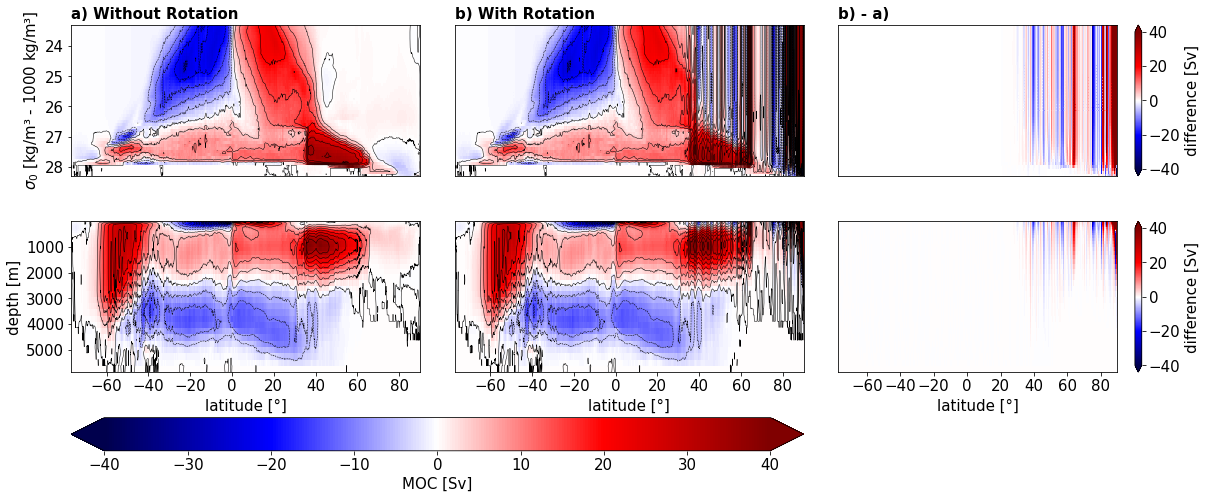

In [412]:
moc_rot_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr0_nest0_step_z.nc').__xarray_dataarray_variable__.mean(dim='time_counter')
mocsig_rot_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr0_nest0_step_sig.nc').__xarray_dataarray_variable__.mean(dim='time_counter')

plt.figure(figsize=(20,10))
gs=GridSpec(3,3) # rows, columns
gs.update(wspace=0.1, hspace=0.3)

def addplot():
    plt.gca().invert_yaxis()
    plt.ylim(28.3,23.3)
    plt.ylabel(r'$\sigma_0$ [kg/m³ - 1000 kg/m³]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
ax = plt.subplot(gs[0,0])
plt.pcolormesh(ref_lat,sig_vec,mocsig_m,vmin=-40,vmax=40,cmap='seismic')
plt.contour(ref_lat,sig_vec,mocsig_m,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('a) Without Rotation',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,1])
plt.pcolormesh(ref_lat,sig_vec,mocsig_rot_m,vmin=-40,vmax=40,cmap='seismic')
plt.contour(ref_lat,sig_vec,mocsig_rot_m,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('b) With Rotation',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,2])
diff = np.array(mocsig_rot_m)-mocsig_m
plt.pcolormesh(ref_lat,sig_vec,diff.where(diff!=0),vmin=-40,vmax=40,cmap='seismic')
plt.title('b) - a)',fontsize=15,fontweight='bold',loc='left')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)


def mocplot(var,abs_diff):
    # remove "northernmost" cells, as the values are NaN there, when v is rotated to meridional before 
    if abs_diff == 'abs':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-40,vmax=40,cmap='seismic')
        plt.contour(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],np.arange(-40,45,5),colors='k',linewidths=0.5)
    if abs_diff == 'diff':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-40,vmax=40,cmap='seismic')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('depth [m]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    return cp

ax = plt.subplot(gs[1,0])
cp=mocplot(moc_m,'abs')

ax = plt.subplot(gs[1,1])
cp=mocplot(moc_rot_m,'abs')
ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[1,2])
diff = np.array(moc_rot_m) - np.array(moc_m)
cpd=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)


ax = plt.subplot(gs[-1,:2])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,extend = 'both',orientation='horizontal',fraction = 1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('MOC [Sv]',fontsize=15)

## Regridding: Sum up the meridional flux over latitudional bands instead of in x-direction
This is only implemented for z-space. In sigma-space, no working chunking setup has been found yet.

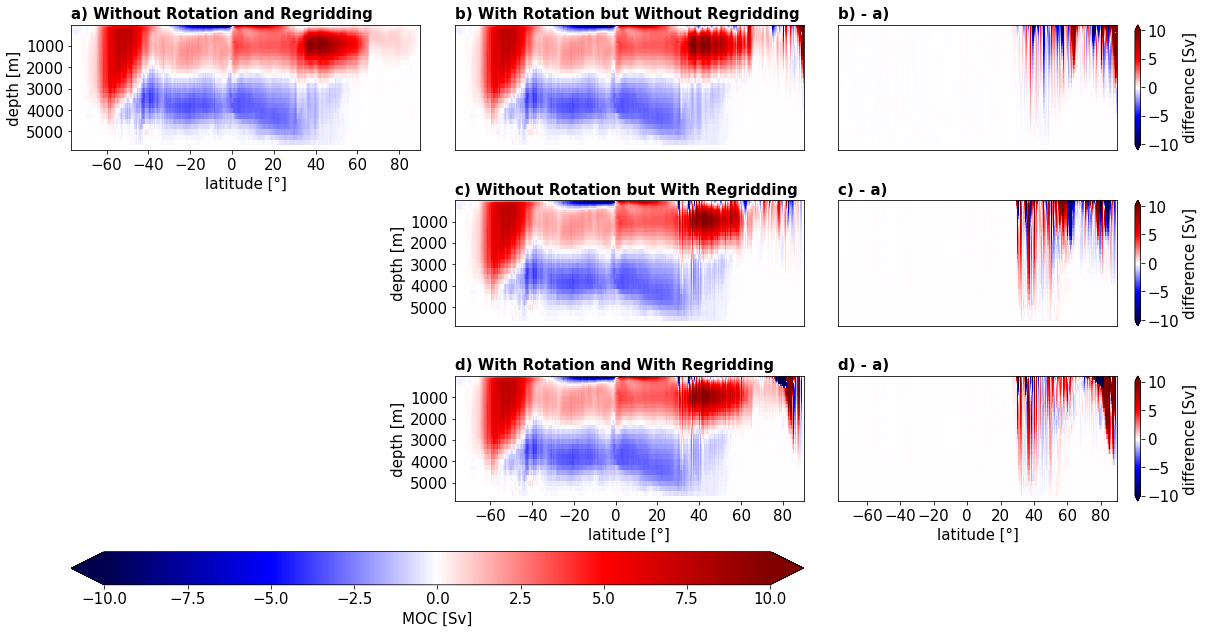

In [413]:
moc_regr_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr1_nest0_ave_z.nc').__xarray_dataarray_variable__
moc_rotregr_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot1_regr1_nest0_ave_z.nc').__xarray_dataarray_variable__

plt.figure(figsize=(20,12))
gs=GridSpec(4,3) # rows, columns
gs.update(wspace=0.1, hspace=0.4)

def mocplot(var,abs_diff):
    # remove "northernmost" cells, as the values are NaN there, when v is rotated to meridional before 
    if abs_diff == 'abs':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_b_m.z,var[:,:-1],vmin=-40,vmax=40,cmap='seismic')
        #plt.contour(ref_lat.isel(y=slice(0,-1)),moc_b_m.z,var[:,:-1],np.arange(-40,45,5),colors='k',linewidths=0.5)
    if abs_diff == 'diff':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_b_m.z,var[:,:-1],vmin=-10, vmax=10,cmap='seismic')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('depth [m]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    return cp

ax = plt.subplot(gs[0,0])
cp=mocplot(moc_m,'abs')
#plt.text(-120,3500,r'z-space',fontsize=15,fontweight='bold',rotation=90)
plt.title('a) Without Rotation and Regridding',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[0,1])
cp=mocplot(moc_rot_m,'abs')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title('b) With Rotation but Without Regridding',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[0,2])
diff = np.array(moc_rot_m) - np.array(moc_m)
cp=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title('b) - a)',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[1,1])
cp=mocplot(moc_regr_m,'abs')
ax.get_xaxis().set_visible(False)
plt.title('c) Without Rotation but With Regridding',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[1,2])
diff = np.array(moc_regr_m) - np.array(moc_m)
cp=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.title('c) - a)',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[2,1])
cp=mocplot(moc_rotregr_m,'abs')
plt.title('d) With Rotation and With Regridding',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[2,2])
diff = np.array(moc_rotregr_m) - np.array(moc_m)
cp=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)
plt.title('d) - a)',fontsize=15,fontweight='bold',loc='left')

ax = plt.subplot(gs[-1,:2])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,extend = 'both',orientation='horizontal',fraction = 1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('MOC [Sv]',fontsize=15)

# Appendix III: Using Nest-Data for the Computations

In [414]:
# load nest surface fields to identify, where the velocity is zero at the nest boundaries
v_tmp = xr.open_mfdataset('/home/shkrschu/_work/SCRATCH/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202/OUT/1_INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_1d_2015*_grid_V.nc',
                          combine='by_coords',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthv':-1,'time_counter':-1,'x':-1,'y':50}).squeeze().vomecrty.rename({'depthv': 'z'})
v_tmp = v_tmp.isel(time_counter=0,z=0)
u_tmp = xr.open_mfdataset('/home/shkrschu/_work/SCRATCH/INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202/OUT/1_INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_1d_2015*_grid_U.nc',
                          combine='by_coords',concat_dim='time_counter', decode_cf=False,
                          chunks={'depthu':-1,'time_counter':-1,'x':-1,'y':50}).squeeze().vozocrtx.rename({'depthu': 'z'})
u_tmp = u_tmp.isel(time_counter=0,z=0)

In [415]:
# get nest locations in terms of respective host indeces, as well as grid-refinement (grf)
with open('/home/shkrschu/NEMOGCM/release-3.6.3.x-berlin/CONFIG/INALT20r.L46.LIM2vp.JRA.XIOS2/KRS0202/AGRIF_FixedGrids.in') as f:
    agrif = [line.rstrip() for line in f]

ia_agrif,ib_agrif,ja_agrif,jb_agrif,grf = [int(n) for n in agrif[1].split()][0:5]

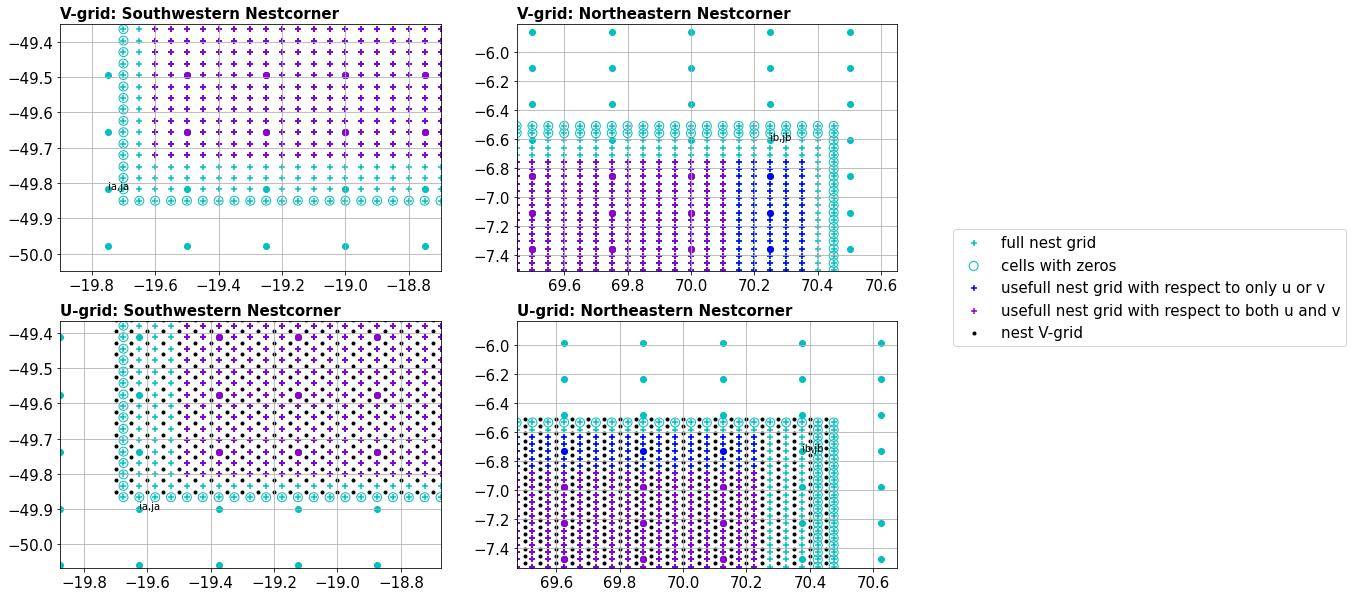

In [416]:
# check, where exactly the "useful" nest sits in the host

# load lon/lat coordinates of U and V-grids 
ds = xr.open_dataset(path_mask+'mesh_mask.nc').squeeze()
lon_bv = ds.glamv
lat_bv = ds.gphiv
lon_bu = ds.glamu
lat_bu = ds.gphiu
ds = xr.open_dataset(path_mask+'1_mesh_mask.nc').squeeze()
lon_nv = ds.glamv
lat_nv = ds.gphiv
lon_nu = ds.glamu
lat_nu = ds.gphiu
    
plt.figure(figsize=(15,10))
def addplot():
    plt.scatter(lon_nv,lat_nv,marker='+',color = 'c',label='full nest grid')
    plt.scatter(lon_bv,lat_bv,marker='o',color = 'c')
    plt.scatter(lon_nv.where(v_tmp==0),lat_nv.where(v_tmp==0),s=80,facecolors='none',edgecolors = 'c',label='cells with zeros')  
    
    plt.scatter(lon_bv[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif+1],lat_bv[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif+1],marker='o',color = 'b')
    plt.scatter(lon_nv[4:-5,2:-2],lat_nv[4:-5,2:-2],marker='+',color = 'b',label='usefull nest grid wrt. to only u or v')
    plt.scatter(lon_bv[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif],lat_bv[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif],marker='o',color = 'darkviolet')
    plt.scatter(lon_nv[4:-5,2:-7],lat_nv[4:-5,2:-7],marker='+',color = 'darkviolet',label='usefull nest grid wrt. to both u or v')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    
plt.subplot(221)
addplot()
plt.axis([lon_nv[0,0]-0.2,lon_nv[0,0]+1,lat_nv[0,0]-0.2,lat_nv[0,0]+0.5])
plt.title('V-grid: Southwestern Nestcorner',fontsize=15,fontweight='bold',loc='left')
plt.text(lon_bv[ja_agrif,ia_agrif].values,lat_bv[ja_agrif,ia_agrif].values,'ia,ja',color='k')

plt.subplot(222)
addplot()
plt.axis([lon_nv[-1,-1]-1,lon_nv[-1,-1]+0.2,lat_nv[-1,-1]-1,lat_nv[-1,-1]+0.7])
plt.title('V-grid: Northeastern Nestcorner',fontsize=15,fontweight='bold',loc='left')
plt.text(lon_bv[jb_agrif,ib_agrif].values,lat_bv[jb_agrif,ib_agrif].values,'ib,jb',color='k')

# v: in INALT20r and ORION10X the nest[4:-5,2:-2] sits at host [ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif+1]

def addplot():
    plt.scatter(lon_nu,lat_nu,marker='+',color = 'c',label='full nest grid')
    plt.scatter(lon_bu,lat_bu,marker='o',color = 'c')
    plt.scatter(lon_nu.where(u_tmp==0),lat_nu.where(u_tmp==0),s=80,facecolors='none',edgecolors = 'c',label='cells with zeros')  
    
    #plt.scatter(lon_nu[:,1],lat_nu[:,-1],s=80,marker = 's',facecolors='none',edgecolors = 'c',label='... and those additionally effected by interpolation onto V-grid')
    #plt.scatter(lon_nu[-2,:],lat_nu[-2,:],s=80,marker = 's',facecolors='none',edgecolors = 'c')
                
    plt.scatter(lon_bu[ja_agrif+1:jb_agrif+1,ia_agrif+1:ib_agrif],lat_bu[ja_agrif+1:jb_agrif+1,ia_agrif+1:ib_agrif],marker='o',color = 'b')
    plt.scatter(lon_nu[2:-2,4:-5],lat_nu[2:-2,4:-5],marker='+',color = 'b',label='usefull nest grid with respect to only u or v')
    plt.scatter(lon_bu[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif],lat_bu[ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif],marker='o',color = 'darkviolet')
    plt.scatter(lon_nu[2:-7,4:-5],lat_nu[2:-7,4:-5],marker='+',color = 'darkviolet',label='usefull nest grid with respect to both u and v')
    
    plt.scatter(lon_nv,lat_nv,marker='.',color = 'k',label='nest V-grid')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()
    
plt.subplot(223)
addplot()
plt.axis([lon_nu[0,0]-0.2,lon_nu[0,0]+1,lat_nu[0,0]-0.2,lat_nu[0,0]+0.5])
plt.title('U-grid: Southwestern Nestcorner',fontsize=15,fontweight='bold',loc='left')
plt.text(lon_bu[ja_agrif,ia_agrif].values,lat_bu[ja_agrif,ia_agrif].values,'ia,ja',color='k')

plt.subplot(224)
addplot()
plt.axis([lon_nu[-1,-1]-1,lon_nu[-1,-1]+0.2,lat_nu[-1,-1]-1,lat_nu[-1,-1]+0.7])
plt.title('U-grid: Northeastern Nestcorner',fontsize=15,fontweight='bold',loc='left')
plt.text(lon_bu[jb_agrif,ib_agrif].values,lat_bu[jb_agrif,ib_agrif].values,'ib,jb',color='k')
plt.legend(loc='upper right',fontsize=15,bbox_to_anchor=(2.2, 1.4))

# u: in INALT20r the nest[2:-2,4:-5] sits at host [ja_agrif+1:jb_agrif+1,ia_agrif+1:ib_agrif]

# to cut the host region that is comparable for both u and v (e.g. for EKE computations: in INALT20r the u-nest[2:-7,4:-5] and the v-nest[4:-5,2:-7] sit at host [ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif]

# for rot == 1, u is interpolated onto the V-grid. In the west, south and north 2 rows are affected by the zeros, in the south 1 row. 
# As they are all cut, for the interpolated u fields the same indices can be used as for v (blue and violet crosses in the top panels)

In INALT20r and ORION10X, the v data of the nest[4:-5,2:-2] sits at host [ja_agrif+1:jb_agrif,ia_agrif+1:ib_agrif+1]. Note that the host indeces are given for the full host-data. If the colums at the cyclic boundaries are removed, the indeces need to be shifted on row in negative x-driection [ja_agrif+1:jb_agrif,ia_agrif:ib_agrif].

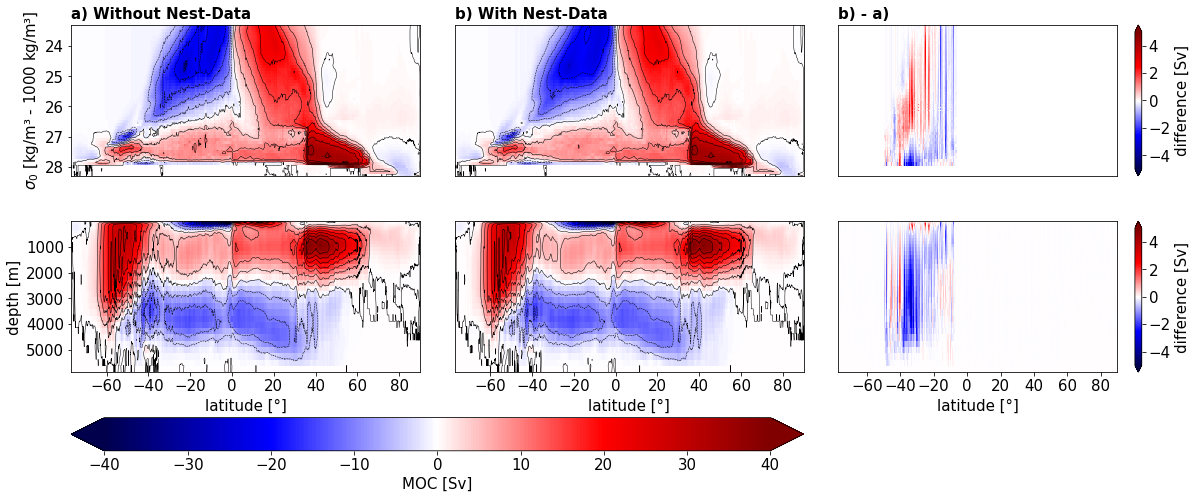

In [417]:
moc_nest_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest1_step_z.nc').__xarray_dataarray_variable__.mean(dim='time_counter')
mocsig_nest_m = xr.open_dataset(path_tmp+'INALT20r.L46.LIM2vp.JRA.XIOS2-KRS0202_2015_2015_moc_rot0_regr0_nest1_step_sig.nc').__xarray_dataarray_variable__.mean(dim='time_counter')

mocmax = 40
mocdiffmax = 5

plt.figure(figsize=(20,10))
gs=GridSpec(3,3) # rows, columns
gs.update(wspace=0.1, hspace=0.3)

def addplot():
    plt.gca().invert_yaxis()
    plt.ylim(28.3,23.3)
    plt.ylabel(r'$\sigma_0$ [kg/m³ - 1000 kg/m³]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
ax = plt.subplot(gs[0,0])
plt.pcolormesh(ref_lat,sig_vec,mocsig_m,vmin=-1*mocmax,vmax=mocmax,cmap='seismic')
plt.contour(ref_lat,sig_vec,mocsig_m,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('a) Without Nest-Data',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,1])
plt.pcolormesh(ref_lat,sig_vec,mocsig_nest_m,vmin=-1*mocmax,vmax=mocmax,cmap='seismic')
plt.contour(ref_lat,sig_vec,mocsig_nest_m,np.arange(-40,45,5),colors='k',linewidths=0.5)
plt.title('b) With Nest-Data',fontsize=15,fontweight='bold',loc='left')
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

ax = plt.subplot(gs[0,2])
diff = np.array(mocsig_nest_m)-mocsig_m
plt.pcolormesh(ref_lat,sig_vec,diff.where(diff!=0),vmin=-1*mocdiffmax,vmax=mocdiffmax,cmap='seismic')
plt.title('b) - a)',fontsize=15,fontweight='bold',loc='left')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
addplot()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)


def mocplot(var,abs_diff):
    # remove "northernmost" cells, as the values are NaN there, when v is rotated to meridional before 
    if abs_diff == 'abs':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-1*mocmax,vmax=mocmax,cmap='seismic')
        plt.contour(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],np.arange(-40,45,5),colors='k',linewidths=0.5)
    if abs_diff == 'diff':
        cp = plt.pcolormesh(ref_lat.isel(y=slice(0,-1)),moc_m.z,var[:,:-1],vmin=-1*mocdiffmax,vmax=mocdiffmax,cmap='seismic')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('depth [m]',fontsize=15)
    plt.xlabel('latitude [°]',fontsize=15)
    return cp

ax = plt.subplot(gs[1,0])
cp=mocplot(moc_m,'abs')

ax = plt.subplot(gs[1,1])
cp=mocplot(moc_nest_m,'abs')
ax.get_yaxis().set_visible(False)

ax = plt.subplot(gs[1,2])
diff = np.array(moc_nest_m) - np.array(moc_m)
cpd=mocplot(diff,'diff')
cbar = plt.colorbar(extend='both',label='difference [Sv]')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('difference [Sv]',fontsize=15)
ax.get_yaxis().set_visible(False)


ax = plt.subplot(gs[-1,:2])
plt.gca().set_visible(False)
cbar = plt.colorbar(cp,extend = 'both',orientation='horizontal',fraction = 1)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('MOC [Sv]',fontsize=15)